# Multi-dimensional scaling with myChEMBL, RDKit and Pandas

### myChEMBL team, ChEMBL group, EMBL-EBI.

This is a slightly modified version of [this](http://rdkit.blogspot.co.uk/search?updated-max=2014-02-02T20:05:00-08:00&max-results=7&start=7&by-date=false) article by Greg Landrum , which in turn is based on [this](http://nbviewer.ipython.org/gist/madgpap/8538507) notebook by George Papadatos.

Scikit-learn makes it quite easy to apply multi-dimensional scaling (MDS) to either reduce the dimensionality of a dataset or to embed distance data into cartesian space. This enables one of the favorite activities of the cheminformatician: producing plots of where compounds land in an 2D space.

In [1]:
%pylab inline
from IPython.display import Image

import pandas as pd
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import DataStructs
from sklearn import manifold
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
rcParams['figure.figsize'] = 8,8

Let's configure our client to use local version of web services. Just delete the cell below, if you want to use the [official version](https://www.ebi.ac.uk/chembl/ws). In that case, you will need internet access.

In [3]:
from chembl_webresource_client.settings import Settings
Settings.Instance().NEW_CLIENT_URL = 'http://localhost/chemblws'
from chembl_webresource_client.new_client import new_client

## Grab the data

I'm going to start with a larger dataset so that I can explore the impact of dataset size on the results. The analysis of George's results are below.

I'll use the Dopamine D3 receptor as the target for this exercise. It's one of the targets we used in both the benchmarking and model fusion papers.

In [4]:
print dir(new_client)
activity = new_client.activity
target='CHEMBL234'
bio = [act for act in activity.filter(target_chembl_id=target)]
data = pd.DataFrame(bio)
data.head()

['__class__', '__delattr__', '__dict__', '__doc__', '__format__', '__getattribute__', '__hash__', '__init__', '__module__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'activity', 'assay', 'atc_class', 'binding_site', 'biotherapeutic', 'cell_line', 'chembl_id_lookup', 'description', 'document', 'image', 'mechanism', 'molecule', 'molecule_form', 'official', 'protein_class', 'similarity', 'source', 'substructure', 'target', 'target_component']


,activity_comment,activity_id,assay_chembl_id,assay_description,assay_type,bao_endpoint,bao_format,canonical_smiles,data_validity_comment,document_chembl_id,...,record_id,standard_flag,standard_relation,standard_type,standard_units,standard_value,target_chembl_id,target_organism,target_pref_name,uo_units
0,None,754819,CHEMBL651365,Displacement of [3H]-spiperone from CHO-K1 cell membranes expressing human dopamine 3 receptors,B,BAO_0000192,BAO_0000219,O[C@H](CCCN1CCN(CC1)c2ncc(F)cn2)c3ccc(F)cc3,None,CHEMBL1126960,...,244391,True,>,Ki,nM,2000,CHEMBL234,Homo sapiens,Dopamine D3 receptor,UO_0000065
1,None,764689,CHEMBL651365,Displacement of [3H]-spiperone from CHO-K1 cell membranes expressing human dopamine 3 receptors,B,BAO_0000192,BAO_0000219,Fc1ccc(cc1)C(=O)CCCN2CCN(CC2)c3ccccn3,None,CHEMBL1126960,...,244387,True,=,Ki,nM,53,CHEMBL234,Homo sapiens,Dopamine D3 receptor,UO_0000065
2,None,764693,CHEMBL651365,Displacement of [3H]-spiperone from CHO-K1 cell membranes expressing human dopamine 3 receptors,B,BAO_0000192,BAO_0000219,O[C@H](CCCN1CCN(CC1)c2ccccn2)c3ccc(F)cc3,None,CHEMBL1126960,...,244390,True,=,Ki,nM,374,CHEMBL234,Homo sapiens,Dopamine D3 receptor,UO_0000065
3,None,772379,CHEMBL651365,Displacement of [3H]-spiperone from CHO-K1 cell membranes expressing human dopamine 3 receptors,B,BAO_0000192,BAO_0000219,OC1(CCN(CCCC(=O)c2ccc(F)cc2)CC1)c3ccc(Cl)cc3,None,CHEMBL1126960,...,244384,True,=,Ki,nM,0.96,CHEMBL234,Homo sapiens,Dopamine D3 receptor,UO_0000065
4,None,775936,CHEMBL651365,Displacement of [3H]-spiperone from CHO-K1 cell membranes expressing human dopamine 3 receptors,B,BAO_0000192,BAO_0000219,O[C@H](CCCN1CCC(O)(CC1)c2ccc(Cl)cc2)c3ccc(F)cc3,None,CHEMBL1126960,...,244383,True,=,Ki,nM,1296,CHEMBL234,Homo sapiens,Dopamine D3 receptor,UO_0000065


In [5]:
data.shape

(6994, 30)

## Remove duplicates

In [6]:
data = data.drop_duplicates(['molecule_chembl_id'])
data.shape

(4541, 30)

## Remove assays with too many or too few compounds

In [7]:
assays = data[['assay_chembl_id','target_chembl_id']].groupby('assay_chembl_id').count()
print assays.shape
assays.head(5)

(476, 1)


,target_chembl_id
assay_chembl_id,
CHEMBL1030601,12
CHEMBL1030747,1
CHEMBL1031083,4
CHEMBL1031401,1
CHEMBL1032031,1


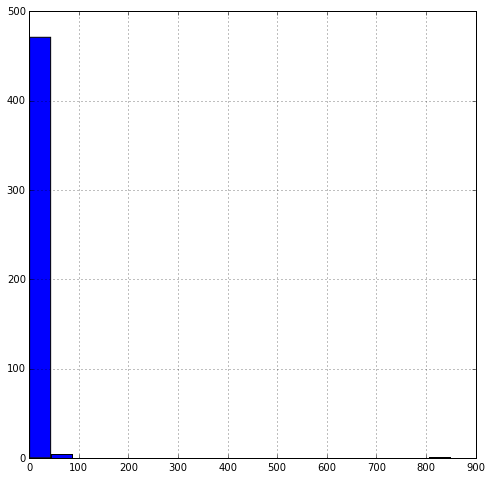

In [8]:
assays.target_chembl_id.hist(bins=20)

(118, 1)


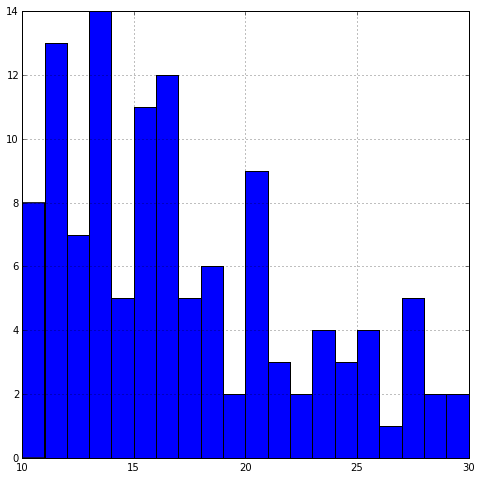

In [9]:
goodassays = assays.ix[(assays.target_chembl_id >= 10)&(assays.target_chembl_id <= 30)]
print goodassays.shape
goodassays.target_chembl_id.hist(bins=20)

In [10]:
data2 = data.ix[data.assay_chembl_id.isin(list(goodassays.index))]
data2.shape

(1974, 30)

## Now get the SMILES

In [11]:
molecule = new_client.molecule
cs = molecule.get(molecule_chembl_id=list(data2['molecule_chembl_id']))
smiles = pd.Series(map(lambda x: x['molecule_structures']['canonical_smiles'], cs), index=data2.index)
data2['SMILES'] = smiles

In [12]:
PandasTools.AddMoleculeColumnToFrame(data2, smilesCol = 'SMILES',includeFingerprints=True)

Let's start by looking at assays that have between 10 and 12 compounds:

In [13]:
assays = data2[['assay_chembl_id','target_chembl_id']].groupby('assay_chembl_id').count()
print assays.shape
goodassays = assays.ix[(assays.target_chembl_id >= 10)&(assays.target_chembl_id <= 12)]
subset = data2.ix[data.assay_chembl_id.isin(list(goodassays.index))]
print subset.shape

(118, 1)
(307, 32)


In [14]:
mols = subset[['molecule_chembl_id','SMILES', 'ROMol', 'assay_chembl_id']]
mols.shape

(307, 4)

,molecule_chembl_id,SMILES,ROMol,assay_chembl_id
51,CHEMBL28607,Oc1ccc(OCCNCc2ccccc2)cc1,,CHEMBL669161
52,CHEMBL156896,Oc1ccccc1N2CCN(Cc3ccccc3)CC2,,CHEMBL669161
53,CHEMBL156732,C(N1CCN(CC1)c2ccccc2)c3ccccc3,,CHEMBL669161
54,CHEMBL347291,Oc1ccccc1OCCNCc2ccccc2,,CHEMBL669161
55,CHEMBL2112913,CS(=O)(=O)Nc1cc(OCCNCc2cccs2)ccc1F,,CHEMBL669161

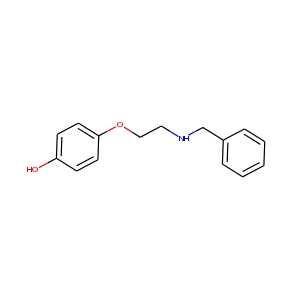
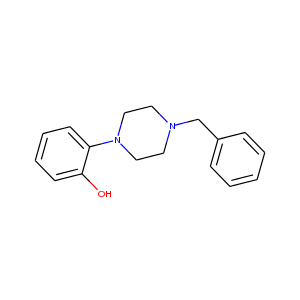
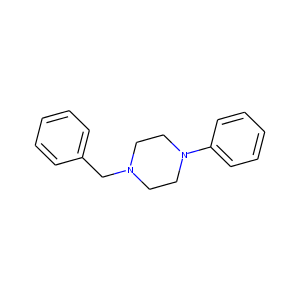
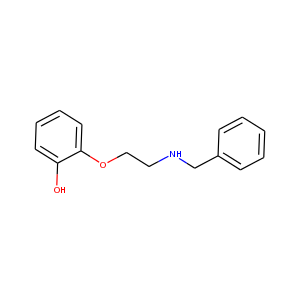
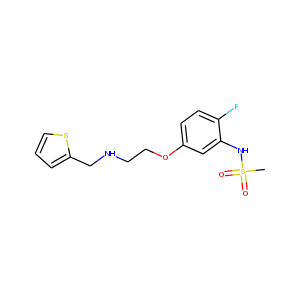

In [15]:
mols.head(5)

Construct fingerprints:

In [16]:
fps = [Chem.GetMorganFingerprintAsBitVect(m,2,nBits=2048) for m in mols['ROMol']]

Now the distance matrix:

In [17]:
dist_mat = []
for i,fp in enumerate(fps):
    dist_mat.append(DataStructs.BulkTanimotoSimilarity(fps[i],fps,returnDistance=1))
dist_mat=numpy.array(dist_mat)

And now do the MDS into 2 dimensions:

In [18]:
mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=3, n_jobs = 4, verbose=1,max_iter=1000)
results = mds.fit(dist_mat)
coords = results.embedding_
print 'Final stress:',mds.stress_

Final stress: 4428.43818223
breaking at iteration 444 with stress 4499.36590662
breaking at iteration 465 with stress 4553.40122563
breaking at iteration 523 with stress 4428.43818223
breaking at iteration 648 with stress 4455.33086664


And plot the points:

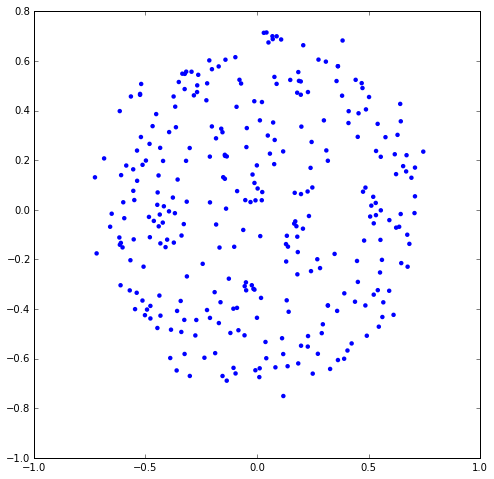

In [19]:
scatter([x for x,y in coords], [y for x,y in coords],edgecolors='none')

Nice picture. How accurate is it?

The strain values above lead me to believe that there are probably some real problems here.

The overall strain value isn't particularly easy to interpret, so we'll check up on things by comparing the embedded distances with the Tanimoto distances we're trying to reproduce.

In [20]:
import random
def distCompare(dmat,coords,nPicks=5000,seed=0xf00d):
    """ picks a random set of pairs of points to compare distances """
    nPts=len(coords)
    random.seed(seed)
    res=[]
    keep=set()
    if nPicks>0:
        while len(res)<nPicks:
            idx1 = random.randint(0,nPts-1)
            idx2 = random.randint(0,nPts-1)
            if idx1==idx2: 
                continue
            if idx1>idx2: 
                idx1,idx2=idx2,idx1
            if (idx1,idx2) in keep: 
                continue
            keep.add((idx1,idx2))
            p1 = coords[idx1]
            p2 = coords[idx2]
            v = p1-p2
            d = sqrt(v.dot(v))
            res.append((dmat[idx1][idx2],d))
    else:
        for idx1 in range(nPts):
            for idx2 in range(idx1+1,nPts):
                p1 = coords[idx1]
                p2 = coords[idx2]
                v = p1-p2
                d = sqrt(v.dot(v))
                res.append((dmat[idx1][idx2],d))
    return res

In [21]:
d = distCompare(dist_mat,coords)

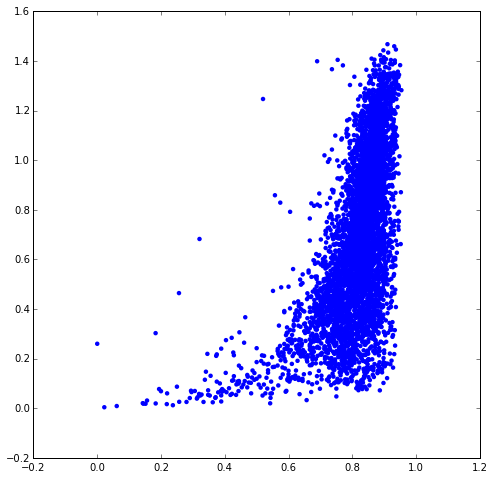

In [22]:
scatter([x for x,y in d],[y for x,y in d],edgecolors='none')

Yikes... that's no good. This really isn't so surprising given how much stress was left.

Let's try increasing the dimensionality to see how much improvement we can get:

In [23]:
mds2 = manifold.MDS(n_components=20, dissimilarity="precomputed", random_state=3, n_jobs = 4, verbose=1,max_iter=1000)
results = mds2.fit(dist_mat)
coords = results.embedding_
print 'Final stress:',mds2.stress_

Final stress: 132.004176625
breaking at iteration 261 with stress 135.478341428
breaking at iteration 263 with stress 132.004176625
breaking at iteration 274 with stress 134.001952298
breaking at iteration 276 with stress 132.042605449


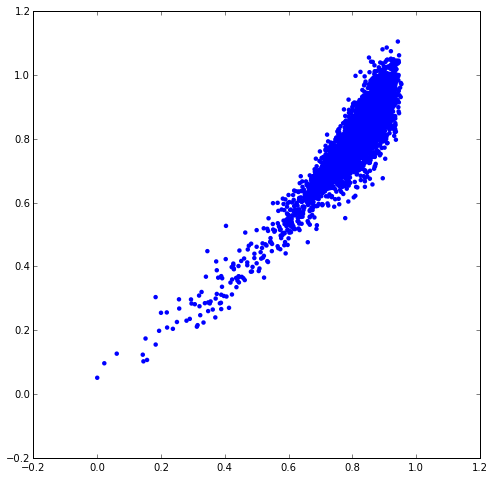

In [24]:
d = distCompare(dist_mat,coords)
scatter([x for x,y in d],[y for x,y in d],edgecolors='none')

Not so bad... of course, we can't visualize 20 dimensions.

What about if we try doing dimensionality reduction on the 20D results instead of using the distance matrix?

In [25]:
mds3 = manifold.MDS(n_components=2, random_state=3, n_jobs = 4, verbose=1,max_iter=1000)
results3 = mds3.fit(coords)
coords3 = results3.embedding_
print 'Final stress:',mds3.stress_

Final stress: 4260.16540185
breaking at iteration 389 with stress 4362.51935411
breaking at iteration 468 with stress 4379.79443911
breaking at iteration 518 with stress 4298.6350002
breaking at iteration 539 with stress 4260.16540185


The strain is still really high. This isn't that surprising given that we already tried the same thing from the distance matrix.

Ok, so MDS doesn't work. Now that we have actual coordinates, we can use some of the other scikit-learn manifold learning approaches for embedding the points.

Instead of jumping all the way to a 2D system, where we're really unlikely to get decent results, start by dropping down to 10D.

First MDS in 10D:

Final stress: 276.892507425
breaking at iteration 203 with stress 279.360860184
breaking at iteration 206 with stress 276.892507425
breaking at iteration 218 with stress 279.455770935
breaking at iteration 229 with stress 283.32712509


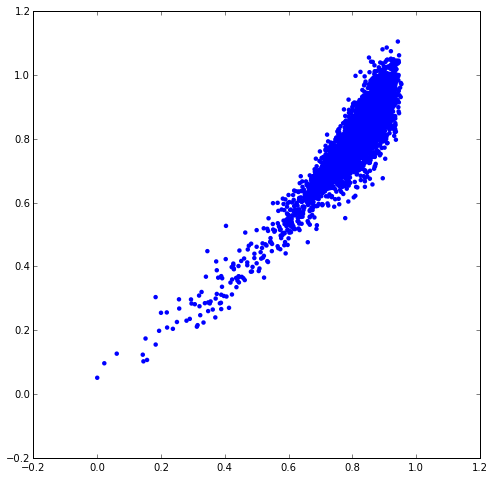

In [26]:
mds3 = manifold.MDS(n_components=10, random_state=3, n_jobs = 4, verbose=1,max_iter=1000)
results3 = mds3.fit(coords)
coords3 = results3.embedding_
print 'Final stress:',results3.stress_
ds = distCompare(dist_mat,coords3)
scatter([x for x,y in d],[y for x,y in d],edgecolors='none')

Now try locally linear embedding:

-9.57586452391e-16


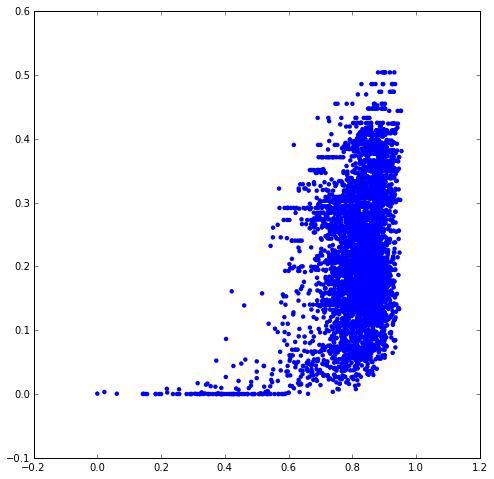

In [27]:
lle = manifold.LocallyLinearEmbedding(n_components=10,random_state=3,max_iter=1000)
results3=lle.fit(coords)
coords3=results3.embedding_
print results3.reconstruction_error_
d = distCompare(dist_mat,coords3)
scatter([x for x,y in d],[y for x,y in d],edgecolors='none')

Ick! What about Isomap?

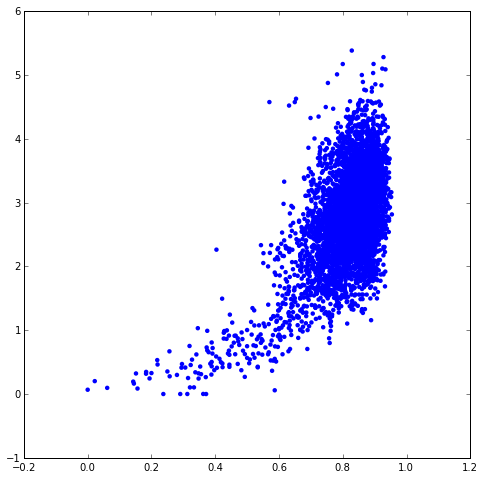

In [28]:
embed = manifold.Isomap(n_components=10,max_iter=1000)
results3=embed.fit(coords)
coords3=results3.embedding_
d = distCompare(dist_mat,coords3)
scatter([x for x,y in d],[y for x,y in d],edgecolors='none')

Also pretty grim. Does spectral embedding work?

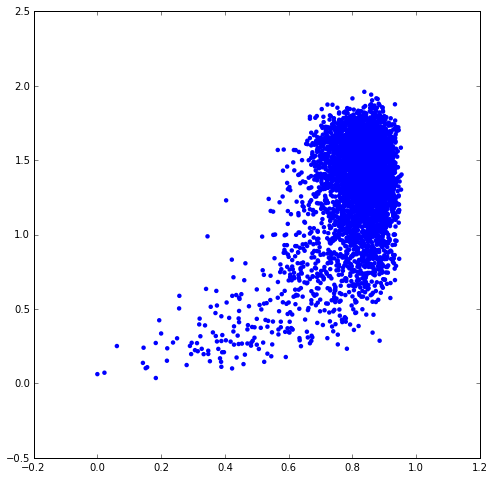

In [29]:
embed = manifold.SpectralEmbedding(n_components=10)
results3=embed.fit(coords)
coords3=results3.embedding_
d = distCompare(dist_mat,coords3)
scatter([x for x,y in d],[y for x,y in d],edgecolors='none')

Hmm, there's at least some signal there. How does spectral embedding do with 2D?

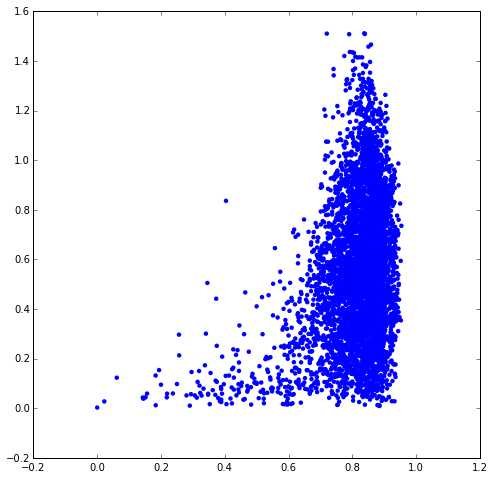

In [30]:
embed = manifold.SpectralEmbedding(n_components=2)
results3=embed.fit(coords)
coords3=results3.embedding_
d = distCompare(dist_mat,coords3)
scatter([x for x,y in d],[y for x,y in d],edgecolors='none')

Not so hot...

## Look at stress vs dimension

We're able to do a reasonable job of embedding into 20 dimensions with MDS. 10 even looks somewhat ok. Let's look at behavior of the residual stress as a function of dimension:

Final stress at dim=140: 16.0915933481 stress per element: 0.0524156135117
Final stress at dim=120: 16.9060057994 stress per element: 0.0550684227992
Final stress at dim=100: 18.667757051 stress per element: 0.0608070262248
Final stress at dim=80: 21.7374728886 stress per element: 0.0708061006144
Final stress at dim=60: 27.8757095246 stress per element: 0.0908003567576
Final stress at dim=40: 44.4923581795 stress per element: 0.144926248142
Final stress at dim=20: 132.004176625 stress per element: 0.429981031351
Final stress at dim=10: 397.363975728 stress per element: 1.29434519781
Final stress at dim=5: 1144.60700935 stress per element: 3.72836159397
Final stress at dim=2: 4428.43818223 stress per element: 14.4248800724


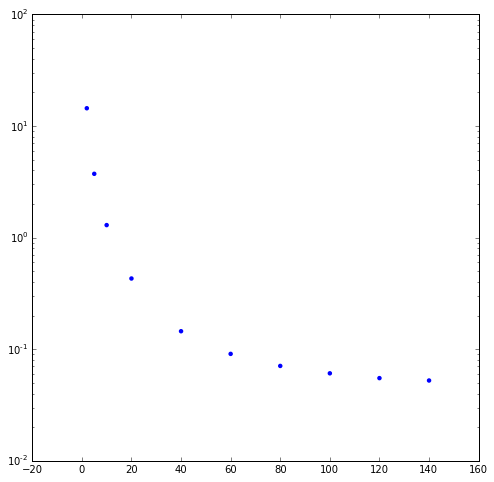

In [31]:
vs={}
for nComps in (140,120,100,80,60,40,20,10,5,2):
    mds3 = manifold.MDS(n_components=nComps, random_state=3, dissimilarity="precomputed",n_jobs = 4, verbose=0,max_iter=1000)
    results3 = mds3.fit(dist_mat)
    print 'Final stress at dim=%d:'%nComps,results3.stress_,'stress per element:',results3.stress_/len(dist_mat)
    vs[nComps]=results3.stress_/len(dist_mat)
scatter(vs.keys(),vs.values(),edgecolors='none')
yscale('log')

Yeah, the stress is going up exponentially with dimension. These data really don't want to be in a 2D space.

Try non-metric embedding

Final stress at dim=140: 21.1641472169 stress per element: 0.0689385902832
Final stress at dim=120: 24.7369581513 stress per element: 0.0805764109162
Final stress at dim=100: 29.0476097359 stress per element: 0.0946176212897
Final stress at dim=80: 36.6289088861 stress per element: 0.119312406795
Final stress at dim=60: 48.2272419251 stress per element: 0.157091993241
Final stress at dim=40: 73.0033267735 stress per element: 0.237795852682
Final stress at dim=20: 153.724626005 stress per element: 0.5007316808
Final stress at dim=10: 332.87365625 stress per element: 1.08427901059
Final stress at dim=5: 752.69341384 stress per element: 2.45177007765
Final stress at dim=2: 2114.54815294 stress per element: 6.88777899981


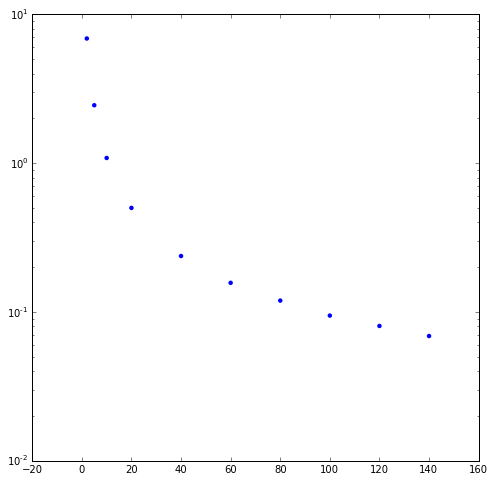

In [32]:
vs={}
for nComps in (140,120,100,80,60,40,20,10,5,2):
    mds3 = manifold.MDS(metric=False,n_components=nComps,random_state=3, dissimilarity="precomputed",n_jobs = 4, verbose=0,max_iter=1000)
    results3 = mds3.fit(dist_mat)
    print 'Final stress at dim=%d:'%nComps,results3.stress_,'stress per element:',results3.stress_/len(dist_mat)
    vs[nComps]=results3.stress_/len(dist_mat)
scatter(vs.keys(),vs.values(),edgecolors='none')
yscale('log')

helps somewhat at lower dimension, but not dramatically. Plus it's a lot slower

## A larger data set

Maybe it's possible to do better with a larger data set? This seems unlikely, but we can at least try:

In [33]:
assays = data2[['assay_chembl_id','target_chembl_id']].groupby('assay_chembl_id').count()
print assays.shape
goodassays = assays.ix[(assays.target_chembl_id >= 10)&(assays.target_chembl_id <= 15)]
subset = data2.ix[data.assay_chembl_id.isin(list(goodassays.index))]
print subset.shape

(118, 1)
(724, 32)


In [34]:
mols = subset[['molecule_chembl_id','SMILES', 'ROMol', 'assay_chembl_id']]
print mols.shape
fps = [Chem.GetMorganFingerprintAsBitVect(m,2,nBits=2048) for m in mols['ROMol']]
dist_mat = []
for i,fp in enumerate(fps):
    dist_mat.append(DataStructs.BulkTanimotoSimilarity(fps[i],fps,returnDistance=1))
dist_mat=numpy.array(dist_mat)    
print dist_mat.shape 

(724, 4)
(724, 724)


Final stress at dim=140: 78.7923391605 stress per element: 0.108829197735
Final stress at dim=120: 85.3877238952 stress per element: 0.117938845159
Final stress at dim=100: 95.7989530062 stress per element: 0.132318995865
Final stress at dim=80: 113.017541319 stress per element: 0.156101576408
Final stress at dim=60: 150.482313274 stress per element: 0.207848498997
Final stress at dim=40: 262.934436056 stress per element: 0.363169110574
Final stress at dim=20: 809.815150801 stress per element: 1.11852921381
Final stress at dim=10: 2471.24628523 stress per element: 3.41332359839
Final stress at dim=5: 6893.74959256 stress per element: 9.52175358089
Final stress at dim=2: 25676.8074957 stress per element: 35.4652037233


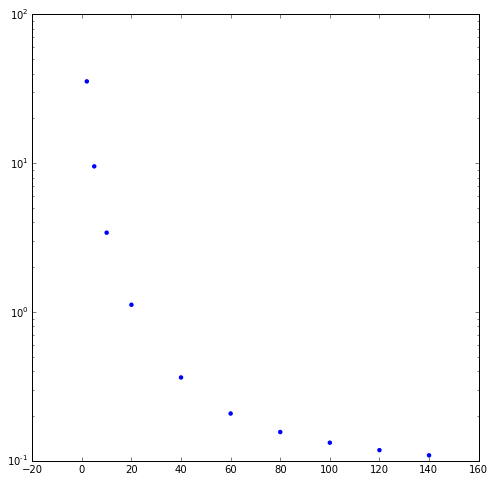

In [35]:
vs={}
for nComps in (140,120,100,80,60,40,20,10,5,2):
    mds3 = manifold.MDS(n_components=nComps, random_state=3, dissimilarity="precomputed",n_jobs = 4, verbose=0,max_iter=1000)
    results3 = mds3.fit(dist_mat)
    print 'Final stress at dim=%d:'%nComps,results3.stress_,'stress per element:',results3.stress_/len(dist_mat)
    vs[nComps]=results3.stress_/len(dist_mat)
scatter(vs.keys(),vs.values(),edgecolors='none')
yscale('log')

Nope, that definitely made things worse.

## and larger still

In [36]:
assays = data2[['assay_chembl_id','target_chembl_id']].groupby('assay_chembl_id').count()
print assays.shape
goodassays = assays.ix[(assays.target_chembl_id >= 10)&(assays.target_chembl_id <= 18)]
subset = data2.ix[data.assay_chembl_id.isin(list(goodassays.index))]
print subset.shape

(118, 1)
(1109, 32)


In [37]:
mols = subset[['molecule_chembl_id', 'SMILES', 'ROMol', 'assay_chembl_id']]
print mols.shape
fps = [Chem.GetMorganFingerprintAsBitVect(m,2,nBits=2048) for m in mols['ROMol']]
dist_mat = []
for i,fp in enumerate(fps):
    dist_mat.append(DataStructs.BulkTanimotoSimilarity(fps[i],fps,returnDistance=1))
dist_mat=numpy.array(dist_mat)    
print dist_mat.shape

(1109, 4)
(1109, 1109)


Final stress at dim=140: 167.736826806 stress per element: 0.151250520113
Final stress at dim=120: 184.264144567 stress per element: 0.166153421611
Final stress at dim=100: 208.215785554 stress per element: 0.187750933773
Final stress at dim=80: 247.185933895 stress per element: 0.222890833088
Final stress at dim=60: 339.762410642 stress per element: 0.306368269289
Final stress at dim=40: 603.628484933 stress per element: 0.544299806072
Final stress at dim=20: 1942.66691968 stress per element: 1.75172851188
Final stress at dim=10: 5937.59445273 stress per element: 5.35400762194
Final stress at dim=5: 16701.0610295 stress per element: 15.0595681059
Final stress at dim=2: 61170.383 stress per element: 55.1581451759


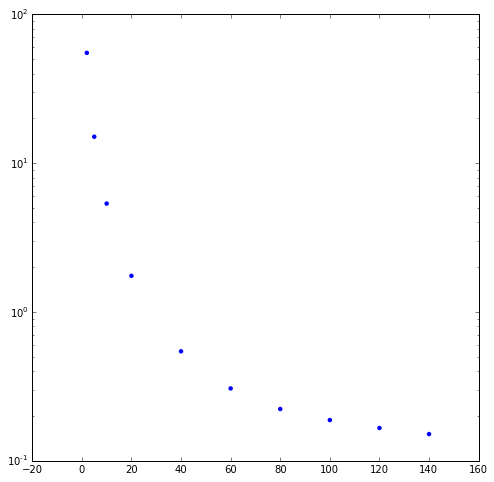

In [38]:
vs={}
for nComps in (140,120,100,80,60,40,20,10,5,2):
    mds3 = manifold.MDS(n_components=nComps, random_state=3, dissimilarity="precomputed",n_jobs = 4, verbose=0,max_iter=1000)
    results3 = mds3.fit(dist_mat)
    print 'Final stress at dim=%d:'%nComps,results3.stress_,'stress per element:',results3.stress_/len(dist_mat)
    vs[nComps]=results3.stress_/len(dist_mat)
scatter(vs.keys(),vs.values(),edgecolors='none')
yscale('log')

Continuing to get worse.

## Try less data

In [40]:
assays = data2[['assay_chembl_id','target_chembl_id']].groupby('assay_chembl_id').count()
print assays.shape
goodassays = assays.ix[assays.target_chembl_id == 15]
subset = data2.ix[data.assay_chembl_id.isin(list(goodassays.index))]
print subset.shape

(118, 1)
(165, 32)


In [41]:
mols = subset[['molecule_chembl_id','SMILES', 'ROMol', 'assay_chembl_id']]
print mols.shape
fps = [Chem.GetMorganFingerprintAsBitVect(m,2,nBits=2048) for m in mols['ROMol']]
dist_mat = []
for i,fp in enumerate(fps):
    dist_mat.append(DataStructs.BulkTanimotoSimilarity(fps[i],fps,returnDistance=1))
dist_mat=numpy.array(dist_mat)    
print dist_mat.shape

(165, 4)
(165, 165)


Final stress at dim=140: 5.07741765398 stress per element: 0.0307722282059
Final stress at dim=120: 5.32922994093 stress per element: 0.0322983632783
Final stress at dim=100: 5.63600494262 stress per element: 0.0341576057128
Final stress at dim=80: 6.23115072171 stress per element: 0.0377645498285
Final stress at dim=60: 7.72000261984 stress per element: 0.0467878946657
Final stress at dim=40: 11.5392153137 stress per element: 0.0699346382647
Final stress at dim=20: 32.0264822227 stress per element: 0.194099892259
Final stress at dim=10: 100.250904661 stress per element: 0.607581240368
Final stress at dim=5: 293.831647814 stress per element: 1.78079786554
Final stress at dim=2: 1194.67811114 stress per element: 7.24047340083


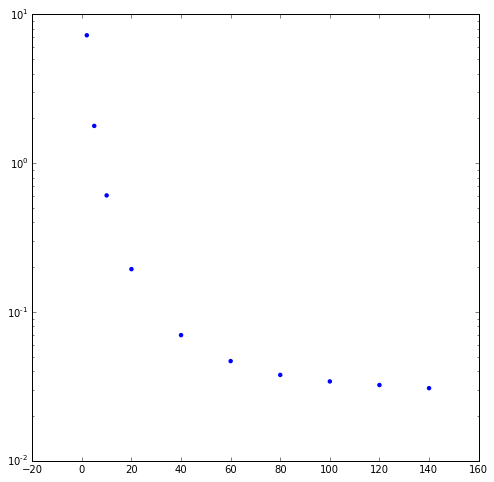

In [42]:
vs={}
for nComps in (140,120,100,80,60,40,20,10,5,2):
    mds3 = manifold.MDS(n_components=nComps, random_state=3, dissimilarity="precomputed",n_jobs = 4, verbose=0,max_iter=1000)
    results3 = mds3.fit(dist_mat)
    print 'Final stress at dim=%d:'%nComps,results3.stress_,'stress per element:',results3.stress_/len(dist_mat)
    vs[nComps]=results3.stress_/len(dist_mat)
scatter(vs.keys(),vs.values(),edgecolors='none')
yscale('log')

That's a lot less stress per point than before, but it's still pretty high. Look at the distances to be sure:

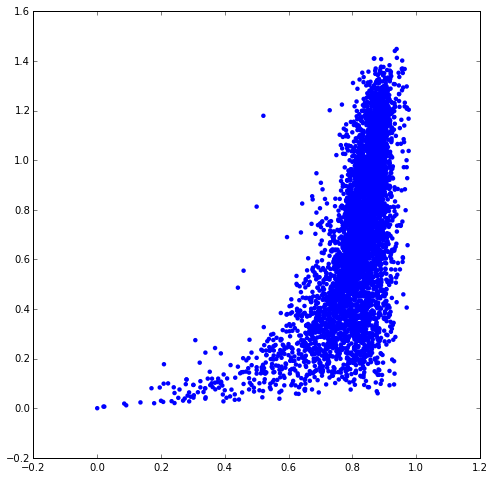

In [43]:
mds3 = manifold.MDS(n_components=2, random_state=3, dissimilarity="precomputed",n_jobs = 4, verbose=0,max_iter=1000)
results3 = mds3.fit(dist_mat)
coords3=results3.embedding_
d = distCompare(dist_mat,coords3)
scatter([x for x,y in d],[y for x,y in d],edgecolors='none')